## University of Arizona - Work Sample
### Anonymized Student Data obtained from [Open University Learning Analytics](https://analyse.kmi.open.ac.uk/open_dataset) 
#### (Database schema and descriptions can be found at that site)

In [1]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3

import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
# for in-memory database

# conn = sqlite3.connect(':memory:')
# c = conn.cursor()

#### Connect to university.db

In [6]:
conn = sqlite3.connect('university.db')
c = conn.cursor()

## 0. Obtain Data & Convert to SQL Database - Do Not Run Again

### Test using pandas to convert csv files to SQL

In [2]:
courses_df = pd.read_csv('data/courses.csv')
courses_df.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


In [3]:
# courses_df.to_sql('courses', conn, "'if_exists'='append'", index=False)

In [4]:
# c.execute('SELECT * FROM courses').fetchall()

### Test with new database

In [5]:
# c.close()

In [6]:
conn = sqlite3.connect('university.db')
c = conn.cursor()

In [7]:
# assessments_df = pd.read_csv('data/assessments.csv')
# assessments_df.head()

In [8]:
# assessments_df.to_sql('assessments', conn, "'if_exists'='append'", index=False)

In [9]:
# Check to see if assessments table present within university.db

c.execute("SELECT name FROM sqlite_master WHERE type = 'table';").fetchall()

[('assessments',),
 ('courses',),
 ('student_assessments',),
 ('student_info',),
 ('student_registration',),
 ('student_vle',),
 ('vle',)]

In [11]:
# manually read-in remaining csv files, I know this is ugly

courses_df = pd.read_csv('data/courses.csv')
student_assessment_df = pd.read_csv('data/studentAssessment.csv')
student_info_df = pd.read_csv('data/studentInfo.csv')
student_registration_df = pd.read_csv('data/studentRegistration.csv')
student_vle_df = pd.read_csv('data/studentVle.csv')
vle_df = pd.read_csv('data/vle.csv')

#### Function to add dataframe to SQL database

In [16]:
def add_df_to_db(df, table_name):
    
    df.to_sql(table_name, conn, "'if_exists'='append'", index=False)

In [24]:
# okay, figuring out the for-loops is going to take longer than doing it manually, here is some more ugliness to enjoy

add_df_to_db(courses_df, 'courses')
add_df_to_db(student_assessment_df, 'student_assessments')
add_df_to_db(student_info_df, 'student_info')
add_df_to_db(student_registration_df, 'student_registration')
add_df_to_db(student_vle_df, 'student_vle')
add_df_to_db(vle_df, 'vle')

In [25]:
c.execute("SELECT name FROM sqlite_master WHERE type = 'table';").fetchall()

[('assessments',),
 ('courses',),
 ('student_assessments',),
 ('student_info',),
 ('student_registration',),
 ('student_vle',),
 ('vle',)]

In [10]:
# check that values are actually in the tables!

# c.execute("SELECT * FROM student_assessments;").fetchall()

## I. Exploratory Data Analysis
### With Some Data Cleaning as Needed

### Student Info - Demographic Data about Students and Their Results

Columns that are not self-explanatory

* imd_band = Index of Multiple Deprivation, where the student lived during the module presentation (score used in the United Kingdom to assess a region based on income, employment, health deprivation and disability, education skills and training, barriers to housing and services, crime, and living environment
* studied_credits = total number of credits for the modules the student is currently studying

In [12]:
student_info_df.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


In [13]:
c.execute('SELECT DISTINCT imd_band from student_info;').fetchall()

[('90-100%',),
 ('20-30%',),
 ('30-40%',),
 ('50-60%',),
 ('80-90%',),
 ('70-80%',),
 (None,),
 ('60-70%',),
 ('40-50%',),
 ('10-20',),
 ('0-10%',)]

In [14]:
student_info_df.isnull().sum()

code_module                0
code_presentation          0
id_student                 0
gender                     0
region                     0
highest_education          0
imd_band                1111
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
dtype: int64

In [15]:
student_info_df.shape

(32593, 12)

In [16]:
student_info_df.imd_band.value_counts()

20-30%     3654
30-40%     3539
10-20      3516
0-10%      3311
40-50%     3256
50-60%     3124
60-70%     2905
70-80%     2879
80-90%     2762
90-100%    2536
Name: imd_band, dtype: int64

In [17]:
student_info_df.final_result.value_counts()

Pass           12361
Withdrawn      10156
Fail            7052
Distinction     3024
Name: final_result, dtype: int64

#### Investigate IMD Index
* IMD Band & Passing

In [22]:
# this doesn't work - does not include Withdrawn column

# imd_and_results = pd.read_sql_query("""
#                                     SELECT imd_band, COUNT(final_result) AS 'pass'
#                                     FROM student_info
#                                     WHERE final_result = 'Pass'
#                                     GROUP BY imd_band
#                                     UNION
#                                     SELECT imd_band, COUNT(final_result) AS 'withdrawn'
#                                     FROM student_info
#                                     WHERE final_result = 'Withdrawn'
#                                     GROUP BY imd_band;""", conn)
# imd_and_results.head()

In [27]:
# do not use 'pass' as column name, as this is a python reserved keyword

imd_and_passing = pd.read_sql_query("""
                                    SELECT imd_band, COUNT(final_result) AS passing
                                    FROM student_info
                                    WHERE final_result = 'Pass'
                                    GROUP BY imd_band;
                                    """, conn)

imd_and_passing

,imd_band,passing
0,None,531
1,0-10%,996
2,10-20,1167
3,20-30%,1226
4,30-40%,1345
5,40-50%,1224
6,50-60%,1227
7,60-70%,1209
8,70-80%,1170
9,80-90%,1165


#### Examine Null IMD Values

In [35]:
imd_nulls = pd.read_sql_query("""
                              SELECT * 
                              FROM student_info
                              WHERE imd_band IS NULL;
                              """, conn)

imd_nulls.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,53025,M,North Region,Post Graduate Qualification,None,55<=,0,60,N,Pass
1,AAA,2013J,71361,M,Ireland,HE Qualification,None,35-55,0,60,N,Pass
2,AAA,2013J,104476,M,Ireland,Post Graduate Qualification,None,35-55,0,60,N,Pass
3,AAA,2013J,114017,F,North Region,Post Graduate Qualification,None,35-55,0,60,N,Pass
4,AAA,2013J,172112,M,Ireland,HE Qualification,None,35-55,0,60,N,Pass


In [36]:
imd_nulls.tail()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
1106,GGG,2013J,589914,M,North Region,Lower Than A Level,None,0-35,0,30,N,Pass
1107,GGG,2014B,575199,F,North Western Region,Lower Than A Level,None,0-35,0,30,N,Pass
1108,GGG,2014B,617889,F,South West Region,Lower Than A Level,None,0-35,0,30,N,Fail
1109,GGG,2014B,634470,F,South Region,A Level or Equivalent,None,0-35,0,30,N,Distinction
1110,GGG,2014J,683974,F,North Region,Lower Than A Level,None,0-35,0,30,N,Distinction


#### Distribution of Passing Scores

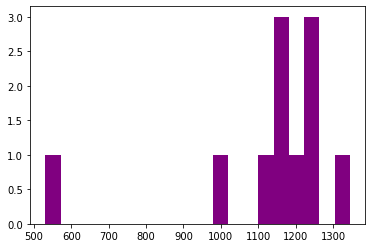

In [32]:
plt.hist(imd_and_passing.passing, bins=20, color='purple');

#### Plot IMD Bands with Passing Scores
* Convert imd_band from string format to percentile

#### Convert String IMD Bands to Numeric Values (Percentiles 0-10, with Null Values as 0 and 90-100% as 10)

#### Function Convert IMD Band Strings

In [46]:
student_info_df.imd_band.value_counts()

20-30%     3654
30-40%     3539
10-20      3516
0-10%      3311
40-50%     3256
50-60%     3124
60-70%     2905
70-80%     2879
80-90%     2762
90-100%    2536
Name: imd_band, dtype: int64

In [44]:
def convert_string_band_to_numeric(col, to_be_replaced, replacement):
    
    col.replace({to_be_replaced:replacement}, inplace=True)

In [47]:
# Test Function

convert_string_band_to_numeric(student_info_df.imd_band, None, 0)

In [48]:
convert_string_band_to_numeric(student_info_df.imd_band, '0-10%', 1)

In [49]:
# Sanity Check

student_info_df.imd_band.value_counts()

20-30%     3654
30-40%     3539
10-20      3516
1          3311
40-50%     3256
50-60%     3124
60-70%     2905
70-80%     2879
80-90%     2762
90-100%    2536
0          1111
Name: imd_band, dtype: int64

In [50]:
# Convert the rest of the columns in student_info_df

convert_string_band_to_numeric(student_info_df.imd_band, '10-20', 2)
convert_string_band_to_numeric(student_info_df.imd_band, '20-30%', 3)
convert_string_band_to_numeric(student_info_df.imd_band, '30-40%', 4)
convert_string_band_to_numeric(student_info_df.imd_band, '40-50%', 5)
convert_string_band_to_numeric(student_info_df.imd_band, '50-60%', 6)
convert_string_band_to_numeric(student_info_df.imd_band, '60-70%', 7)
convert_string_band_to_numeric(student_info_df.imd_band, '70-80%', 8)
convert_string_band_to_numeric(student_info_df.imd_band, '80-90%', 9)
convert_string_band_to_numeric(student_info_df.imd_band, '90-100%', 10)

In [52]:
student_info_df.imd_band.value_counts()

3     3654
4     3539
2     3516
1     3311
5     3256
6     3124
7     2905
8     2879
9     2762
10    2536
0     1111
Name: imd_band, dtype: int64

#### Convert final results to numeric
* Fail = 0
* Withdrawn = 1
* Pass = 2
* Distinction = 3

In [55]:
student_info_df.final_result.value_counts()

Pass           12361
Withdrawn      10156
Fail            7052
Distinction     3024
Name: final_result, dtype: int64

In [59]:
student_info_df.final_result.replace({'Fail': 0, 'Withdrawn': 1, 'Pass': 2, 'Distinction': 3}, inplace=True)
student_info_df.final_result.value_counts()

2    12361
1    10156
0     7052
3     3024
Name: final_result, dtype: int64

#### Correlation Heatmap to Compare IMD Bands with Final Results

In [61]:
student_info_df.corr()

,id_student,imd_band,num_of_prev_attempts,studied_credits,final_result
id_student,1.000000,0.026922,0.011473,-0.003868,0.032757
imd_band,0.026922,1.000000,-0.030339,-0.039354,0.098656
num_of_prev_attempts,0.011473,-0.030339,1.000000,0.181729,-0.118649
studied_credits,-0.003868,-0.039354,0.181729,1.000000,-0.073889
final_result,0.032757,0.098656,-0.118649,-0.073889,1.000000


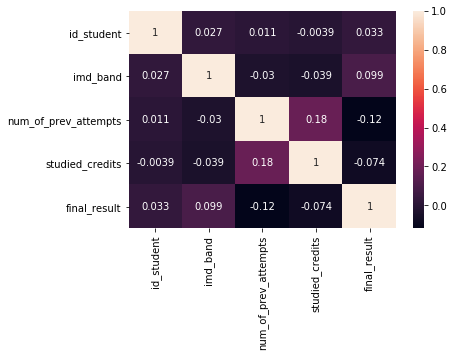

In [62]:
sns.heatmap(student_info_df.corr(), annot=True);

#### Interpretation of Heatmap - Highest Correlations
* Number of Previous Attempts & Studied Credits (Positive Correlation)
* IMD Band & Final Results (Positive Correlation)

## Example Query
* Is there a course with significantly more "Withdrawn" scores than others?
* Are there other correlations with "Withdrawn" scores such as student demographics?
    * IMD Band
    * Age Band
    * Gender
    * Highest Education
    * Disability - disability in the UK is defined as a mental or physical impairment which adversely affects one's ability to carry out normal day-to-day activities
    
* Academic Statistics
    * Number of Previous attempts
    * Date of "unregistration" - number of days relative to the start of the module when the student withdrew from the course
    

In [63]:
# Table Names Refresher

c.execute("SELECT name FROM sqlite_master WHERE type = 'table';").fetchall()

[('assessments',),
 ('courses',),
 ('student_assessments',),
 ('student_info',),
 ('student_registration',),
 ('student_vle',),
 ('vle',)]

In [67]:
# column names for assessments table

c.execute("PRAGMA table_info(student_assessments)").fetchall()

[(0, 'id_assessment', 'INTEGER', 0, None, 0),
 (1, 'id_student', 'INTEGER', 0, None, 0),
 (2, 'date_submitted', 'INTEGER', 0, None, 0),
 (3, 'is_banked', 'INTEGER', 0, None, 0),
 (4, 'score', 'REAL', 0, None, 0)]

In [69]:
# Check to see 'score'

# c.execute('SELECT DISTINCT score FROM student_assessments;').fetchall()
# no, this just gives the numeric scores from 0 - 100

In [72]:
c.execute("SELECT final_result, COUNT(final_result) FROM student_info GROUP BY final_result;").fetchall()

[('Distinction', 3024), ('Fail', 7052), ('Pass', 12361), ('Withdrawn', 10156)]

In [73]:
c.execute("PRAGMA table_info(student_info)").fetchall()

[(0, 'code_module', 'TEXT', 0, None, 0),
 (1, 'code_presentation', 'TEXT', 0, None, 0),
 (2, 'id_student', 'INTEGER', 0, None, 0),
 (3, 'gender', 'TEXT', 0, None, 0),
 (4, 'region', 'TEXT', 0, None, 0),
 (5, 'highest_education', 'TEXT', 0, None, 0),
 (6, 'imd_band', 'TEXT', 0, None, 0),
 (7, 'age_band', 'TEXT', 0, None, 0),
 (8, 'num_of_prev_attempts', 'INTEGER', 0, None, 0),
 (9, 'studied_credits', 'INTEGER', 0, None, 0),
 (10, 'disability', 'TEXT', 0, None, 0),
 (11, 'final_result', 'TEXT', 0, None, 0)]

In [78]:
c.execute("""SELECT COUNT(code_module),
        code_module
        FROM student_info
        WHERE final_result = 'Withdrawn'
        GROUP BY code_module
        ORDER BY COUNT(code_module) DESC
        LIMIT 10;""").fetchall()

[(2403, 'FFF'),
 (2388, 'BBB'),
 (2250, 'DDD'),
 (1975, 'CCC'),
 (722, 'EEE'),
 (292, 'GGG'),
 (126, 'AAA')]

Only 7 different code modules. Could examine the differences between the module with the most W's (FFF) and the one with the least (AAA).

In [80]:
# Check some demographics of the students who took FFF and also had a W

c.execute("""
        SELECT age_band,
        COUNT(age_band)
        FROM student_info
        WHERE (final_result = 'Withdrawn' AND code_module = 'FFF')
        GROUP BY age_band;
        """).fetchall()

[('0-35', 1790), ('35-55', 609), ('55<=', 4)]

In [81]:
# Examine age bands

c.execute("SELECT DISTINCT age_band FROM student_info;").fetchall()

[('55<=',), ('35-55',), ('0-35',)]

In [84]:
# Check more demographics

c.execute("""
        SELECT age_band, COUNT(age_band),
        gender, COUNT(gender),
        imd_band, COUNT(imd_band),
        disability, COUNT(disability),
        highest_education, COUNT(highest_education),
        num_of_prev_attempts, COUNT(num_of_prev_attempts)
        FROM student_info
        WHERE (final_result = 'Withdrawn' AND code_module = 'FFF')
        GROUP BY age_band, gender, imd_band, disability, highest_education, num_of_prev_attempts;
        """).fetchall()

[('0-35', 1, 'F', 1, None, 0, 'N', 1, 'A Level or Equivalent', 1, 0, 1),
 ('0-35', 2, 'F', 2, None, 0, 'N', 2, 'HE Qualification', 2, 0, 2),
 ('0-35', 4, 'F', 4, None, 0, 'N', 4, 'Lower Than A Level', 4, 0, 4),
 ('0-35', 1, 'F', 1, None, 0, 'N', 1, 'No Formal quals', 1, 0, 1),
 ('0-35', 1, 'F', 1, None, 0, 'Y', 1, 'Lower Than A Level', 1, 0, 1),
 ('0-35',
  16,
  'F',
  16,
  '0-10%',
  16,
  'N',
  16,
  'A Level or Equivalent',
  16,
  0,
  16),
 ('0-35', 2, 'F', 2, '0-10%', 2, 'N', 2, 'A Level or Equivalent', 2, 1, 2),
 ('0-35', 1, 'F', 1, '0-10%', 1, 'N', 1, 'A Level or Equivalent', 1, 2, 1),
 ('0-35', 2, 'F', 2, '0-10%', 2, 'N', 2, 'HE Qualification', 2, 0, 2),
 ('0-35', 1, 'F', 1, '0-10%', 1, 'N', 1, 'HE Qualification', 1, 1, 1),
 ('0-35', 1, 'F', 1, '0-10%', 1, 'N', 1, 'HE Qualification', 1, 2, 1),
 ('0-35', 22, 'F', 22, '0-10%', 22, 'N', 22, 'Lower Than A Level', 22, 0, 22),
 ('0-35', 1, 'F', 1, '0-10%', 1, 'N', 1, 'Lower Than A Level', 1, 1, 1),
 ('0-35', 1, 'F', 1, '0-10%', 1

In [ ]:
SELECT 
     SUM(CASE WHEN column1 IS NOT NULL THEN 1 ELSE 0 END) AS column1_count
    ,SUM(CASE WHEN column2 IS NOT NULL THEN 1 ELSE 0 END) AS column2_count
    ,SUM(CASE WHEN column3 IS NOT NULL THEN 1 ELSE 0 END) AS column3_count
FROM table

In [87]:
c.execute("""
        SELECT
        gender, COUNT(CASE WHEN gender IS NOT NULL THEN 1 ELSE 0 END),
        imd_band, COUNT(CASE WHEN imd_band IS NOT NULL THEN 1 ELSE 0 END)
        FROM
        student_info
        GROUP BY gender, imd_band;
        """).fetchall()

[('F', 303, None, 303),
 ('F', 1706, '0-10%', 1706),
 ('F', 1723, '10-20', 1723),
 ('F', 1822, '20-30%', 1822),
 ('F', 1598, '30-40%', 1598),
 ('F', 1537, '40-50%', 1537),
 ('F', 1450, '50-60%', 1450),
 ('F', 1301, '60-70%', 1301),
 ('F', 1189, '70-80%', 1189),
 ('F', 1127, '80-90%', 1127),
 ('F', 962, '90-100%', 962),
 ('M', 808, None, 808),
 ('M', 1605, '0-10%', 1605),
 ('M', 1793, '10-20', 1793),
 ('M', 1832, '20-30%', 1832),
 ('M', 1941, '30-40%', 1941),
 ('M', 1719, '40-50%', 1719),
 ('M', 1674, '50-60%', 1674),
 ('M', 1604, '60-70%', 1604),
 ('M', 1690, '70-80%', 1690),
 ('M', 1635, '80-90%', 1635),
 ('M', 1574, '90-100%', 1574)]

In [96]:
# Create CSV file for Dashboard Exploration - courses with highest and lowest withdraws

withdraw_df = pd.read_sql_query("""
                                SELECT student_info.id_student,
                                student_info.code_module,
                                gender,
                                age_band,
                                imd_band,
                                num_of_prev_attempts,
                                highest_education,
                                disability,
                                studied_credits,
                                region,
                                student_registration.date_unregistration,
                                final_result
                                FROM student_info
                                LEFT JOIN student_registration
                                ON student_info.id_student = student_registration.id_student
                                WHERE (student_info.code_module = 'FFF' OR student_info.code_module = 'AAA')
                                AND
                                final_result = 'Withdrawn'
                                GROUP BY student_info.id_student;
                                """, conn)

withdraw_df.head()

,id_student,code_module,gender,age_band,imd_band,num_of_prev_attempts,highest_education,disability,studied_credits,date_unregistration,final_result
0,26269,FFF,M,35-55,0-10%,0,Lower Than A Level,N,60,-12.0,Withdrawn
1,30268,AAA,F,35-55,30-40%,0,A Level or Equivalent,Y,60,12.0,Withdrawn
2,33600,FFF,F,35-55,40-50%,0,A Level or Equivalent,N,150,-66.0,Withdrawn
3,34293,FFF,M,0-35,60-70%,0,Lower Than A Level,Y,60,90.0,Withdrawn
4,34731,FFF,M,0-35,20-30%,0,A Level or Equivalent,N,60,136.0,Withdrawn


In [91]:
c.execute("PRAGMA table_info(student_registration)").fetchall()

[(0, 'code_module', 'TEXT', 0, None, 0),
 (1, 'code_presentation', 'TEXT', 0, None, 0),
 (2, 'id_student', 'INTEGER', 0, None, 0),
 (3, 'date_registration', 'REAL', 0, None, 0),
 (4, 'date_unregistration', 'REAL', 0, None, 0)]

In [97]:
withdraw_df.shape

(2385, 11)

In [98]:
withdraw_df.to_csv('withdrawn_fff_aaa.csv', index=False)

In [101]:
# All Withdrawns

all_withdrawn = pd.read_sql_query("""
                                SELECT student_info.id_student,
                                student_info.code_module,
                                gender,
                                age_band,
                                imd_band,
                                region,
                                num_of_prev_attempts,
                                highest_education,
                                disability,
                                studied_credits,
                                student_registration.date_unregistration
                                FROM student_info
                                LEFT JOIN student_registration
                                ON student_info.id_student = student_registration.id_student
                                WHERE final_result = 'Withdrawn'
                                GROUP BY student_info.id_student;
                                """, conn)

all_withdrawn.head()

,id_student,code_module,gender,age_band,imd_band,region,num_of_prev_attempts,highest_education,disability,studied_credits,date_unregistration
0,3733,DDD,M,55<=,90-100%,South Region,0,HE Qualification,N,60,-8.0
1,8462,DDD,M,55<=,30-40%,London Region,0,HE Qualification,N,90,18.0
2,23632,BBB,F,0-35,40-50%,East Anglian Region,0,A Level or Equivalent,N,60,-51.0
3,24213,DDD,F,0-35,40-50%,East Anglian Region,0,A Level or Equivalent,N,90,NaN
4,25261,CCC,F,0-35,40-50%,Scotland,0,HE Qualification,N,60,51.0


In [102]:
all_withdrawn.to_csv('all_withdrawn.csv', index=False)

## Average Grades for Courses

In [103]:
# Examine assessments table

c.execute("PRAGMA table_info(assessments)").fetchall()

[(0, 'code_module', 'TEXT', 0, None, 0),
 (1, 'code_presentation', 'TEXT', 0, None, 0),
 (2, 'id_assessment', 'INTEGER', 0, None, 0),
 (3, 'assessment_type', 'TEXT', 0, None, 0),
 (4, 'date', 'REAL', 0, None, 0),
 (5, 'weight', 'REAL', 0, None, 0)]

In [104]:
c.execute("SELECT * FROM assessments LIMIT 1;").fetchall()

[('AAA', '2013J', 1752, 'TMA', 19.0, 10.0)]

In [111]:
c.execute("""
        SELECT DISTINCT code_module
        FROM assessments
        UNION
        SELECT DISTINCT code_presentation
        FROM assessments;
        """).fetchall()

[('2013B',),
 ('2013J',),
 ('2014B',),
 ('2014J',),
 ('AAA',),
 ('BBB',),
 ('CCC',),
 ('DDD',),
 ('EEE',),
 ('FFF',),
 ('GGG',)]

In [109]:
c.execute("SELECT DISTINCT code_module, code_presentation FROM assessments;").fetchall()

[('AAA', '2013J'),
 ('AAA', '2014J'),
 ('BBB', '2013B'),
 ('BBB', '2013J'),
 ('BBB', '2014B'),
 ('BBB', '2014J'),
 ('CCC', '2014B'),
 ('CCC', '2014J'),
 ('DDD', '2013B'),
 ('DDD', '2013J'),
 ('DDD', '2014B'),
 ('DDD', '2014J'),
 ('EEE', '2013J'),
 ('EEE', '2014B'),
 ('EEE', '2014J'),
 ('FFF', '2013B'),
 ('FFF', '2013J'),
 ('FFF', '2014B'),
 ('FFF', '2014J'),
 ('GGG', '2013J'),
 ('GGG', '2014B'),
 ('GGG', '2014J')]

In [118]:
# keys to match for assessments and student_assessments is id_assessment; student_assessment contains score; assessments
# contains code_module

c.execute("""
        SELECT 
        assessments.code_module,
        MIN(score), MAX(score), AVG(score)
        FROM student_assessments
        LEFT JOIN
        assessments
        ON student_assessments.id_assessment = assessments.id_assessment
        GROUP BY assessments.code_module;
        """).fetchall()

[('AAA', 0.0, 98.0, 69.03051493960585),
 ('BBB', 0.0, 100.0, 76.7063682263431),
 ('CCC', 0.0, 100.0, 73.2613978551429),
 ('DDD', 0.0, 100.0, 70.09079993509654),
 ('EEE', 0.0, 100.0, 81.18006593963987),
 ('FFF', 0.0, 100.0, 77.70759006007047),
 ('GGG', 0.0, 100.0, 79.70049293460401)]

### Non-Pandas Way

In [8]:
# this works, but the pandas option is way better because you don't have to manually input column names

# open in-memory database 

# con = sqlite3.connect(":memory:")
# cur = con.cursor()
# cur.execute("CREATE TABLE courses (code_module, code_presentation, module_presentation_length);")

# with open('data/courses.csv','rb') as fin:
#     dr = csv.DictReader(fin)
#     # dicts = ({'code_module': line[0], 'code_presentation': line[1], 'module_presentation_length': line[2]} for line in dr)
#     to_db = ((i['code_module'], i['code_presentation'], i['module_presentation_length']) for i in dicts)

# cur.executemany("INSERT INTO courses (code_module, code_presentation, module_presentation_length) VALUES (?, ?, ?);", to_db)
# con.commit()

# import csv, sqlite3

# con = sqlite3.connect(":memory:")
# cur = con.cursor()
# cur.execute("CREATE TABLE t (col1, col2);") # use your column names here

# with open('data.csv','rb') as fin: # `with` statement available in 2.5+
#     # csv.DictReader uses first line in file for column headings by default
#     dr = csv.DictReader(fin) # comma is default delimiter
#     to_db = [(i['col1'], i['col2']) for i in dr]

# cur.executemany("INSERT INTO t (col1, col2) VALUES (?, ?);", to_db)
# con.commit()
# con.close()

In [6]:
# con.close()

In [7]:
# this code shows that the table courses has been created
# cur.execute("SELECT name FROM sqlite_master WHERE type = 'table';").fetchall()